In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn import over_sampling
from businessscoring import businessgain

In [2]:
from Feature_Engineering import feature_engineering

In [3]:
features = feature_engineering(j_flag=1)

In [4]:
features.columns
features['Norm_FraudNeighbors'] = features['FraudNeighbor_Count']/(features['NetworkDegree'])  
features = features.fillna(0)
#features['NoPhysicianCount'] = features['NoPhysicianCount']/features['Phys_Count'] 
features['Gender1'] = features['Gender1']/features['Patient_Count']  
features['Race1'] = features['Race1']/features['Patient_Count']
features['Race2'] = features['Race2']/features['Patient_Count']
features['Race3'] = features['Race3']/features['Patient_Count']
conditions=['ChronicCond_Alzheimer_2','ChronicCond_KidneyDisease_2','ChronicCond_Cancer_2',\
            'ChronicCond_ObstrPulmonary_2','ChronicCond_Depression_2','ChronicCond_Diabetes_2',\
            'ChronicCond_IschemicHeart_2','ChronicCond_Osteoporasis_2','ChronicCond_rheumatoidarthritis_2',\
            'ChronicCond_stroke_2']
for condition in conditions:
    features[condition] = features[condition]/features['Patient_Count']


In [5]:
features

,Provider,Phys_Count,Patient_Count,Norm_Patient_Count,Claim_Count,Norm_Claim_Count,Service_Type,Both_Service,Inpatient,Outpatient,...,Diagnosis_1_Count,Diagnosis_2_Count,Diagnosis_3_Count,Diagnosis_4_Count,Diagnosis_5_Count,Diagnosis_6_Count,Diagnosis_7_Count,Diagnosis_8_Count,Diagnosis_9_Count,Norm_FraudNeighbors
0,PRV51001,14,24,1.71,25,1.79,Both_Service,1,0,0,...,24.0,16.0,10.0,8.0,8.0,8.0,3.0,2.0,1.0,0.0
1,PRV51003,44,117,2.66,132,3.00,Both_Service,1,0,0,...,132.0,112.0,92.0,78.0,66.0,58.0,55.0,50.0,45.0,0.0
2,PRV51004,38,138,3.63,149,3.92,Outpatient,0,0,1,...,143.0,91.0,56.0,34.0,24.0,16.0,9.0,8.0,4.0,0.0
3,PRV51005,6,495,82.50,1165,194.17,Outpatient,0,0,1,...,1149.0,723.0,455.0,287.0,164.0,100.0,68.0,43.0,26.0,0.0
4,PRV51007,10,58,5.80,72,7.20,Both_Service,1,0,0,...,72.0,46.0,29.0,21.0,14.0,12.0,9.0,6.0,5.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,1,24,24.00,28,28.00,Outpatient,0,0,1,...,27.0,16.0,8.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0
5406,PRV57760,3,9,3.00,22,7.33,Outpatient,0,0,1,...,22.0,11.0,8.0,5.0,3.0,2.0,1.0,0.0,0.0,0.0
5407,PRV57761,2,67,33.50,82,41.00,Outpatient,0,0,1,...,82.0,55.0,32.0,23.0,11.0,8.0,4.0,2.0,2.0,0.0
5408,PRV57762,1,1,1.00,1,1.00,Outpatient,0,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
len(features.columns)

65

In [7]:
features['PotentialFraud'] = features['PotentialFraud'].map({'No': 0, 'Yes': 1})

In [8]:
X = features.drop(['PotentialFraud', 'Service_Type','Provider', 'Inpatient_Count', 'Outpatient_Count',
                  'Patient_Count', 'DuplicateClaims', 'Claim_Count'], axis=1)
y = features['PotentialFraud'] 

In [9]:
#create seperate dataset with dummy variables to add back after scaling
non_num = X[['isFraudConnected','Inpatient','Outpatient','Both_Service']]

#drop dummy variables
X = X.drop(['isFraudConnected','Inpatient','Outpatient','Both_Service'], axis =1)

In [10]:
#scale on the training set 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=(X.columns), index=X.index)
X_scaled = pd.concat((X_scaled, non_num), axis=1)
X_scaled.head()

,Phys_Count,Norm_Patient_Count,Norm_Claim_Count,Norm_Inpatient_Count,Norm_Outpatient_Count,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,...,Diagnosis_5_Count,Diagnosis_6_Count,Diagnosis_7_Count,Diagnosis_8_Count,Diagnosis_9_Count,Norm_FraudNeighbors,isFraudConnected,Inpatient,Outpatient,Both_Service
0,0.470588,-0.155665,-0.165527,1.538462,-1.538462,0.0,-0.087569,2.881274,1.375,-0.315372,...,0.0625,0.230769,0.0,-0.125,-0.142857,0.0,0.0,0,0,1
1,2.235294,0.031527,0.000000,3.615385,-3.615385,0.0,1.250611,3.374576,1.500,-0.017509,...,3.6875,4.076923,5.2,5.875,6.142857,0.0,0.0,0,0,1
2,1.882353,0.222660,0.125855,0.000000,0.000000,0.0,-0.093840,-0.006281,-0.375,-0.647981,...,1.0625,0.846154,0.6,0.625,0.285714,0.0,0.0,0,1,0
3,0.000000,15.763547,26.151847,0.000000,0.000000,0.0,-0.298150,-0.083279,-0.625,-0.007999,...,9.8125,7.307692,6.5,5.000,3.428571,0.0,0.0,0,1,0
4,0.235294,0.650246,0.574555,0.307692,-0.307692,0.0,-0.376059,0.108817,-0.625,0.300145,...,0.4375,0.538462,0.6,0.375,0.428571,0.2,1.0,0,0,1


In [11]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True);
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# SMOTE upsampling for all models
oversample = over_sampling.SMOTE()
X_train_Bal, y_train_Bal = oversample.fit_resample(X_train, y_train)

y_train_Bal.value_counts()

1    3923
0    3923
Name: PotentialFraud, dtype: int64

In [13]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

In [14]:
# Data Frame to compare models
business_scores = pd.DataFrame(columns=('Model', 'Score'))

### Examining VIF

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_train_Bal.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [round(variance_inflation_factor(X_train_Bal.values, i),3)
                          for i in range(len(X_train_Bal.columns))] 
  
print(vif_data)

                              feature          VIF
0                          Phys_Count        4.532
1                  Norm_Patient_Count       37.720
2                    Norm_Claim_Count       43.123
3                Norm_Inpatient_Count  1486886.609
4               Norm_Outpatient_Count  1486640.672
5            Duplicate_Claims_Percent        1.090
6                    AvgClaimDuration        3.275
7                            Avg_Cost       10.194
8                             Avg_Age       17.898
9                             Gender1        1.115
10                            Gender2      743.965
11                              Race1        7.746
12                              Race2        6.308
13                              Race3        4.516
14                              Race5        4.488
15            ChronicCond_Alzheimer_1      492.232
16            ChronicCond_Alzheimer_2        1.332
17        ChronicCond_KidneyDisease_1      518.685
18        ChronicCond_KidneyDis

### Examining Correlation Matrix

In [16]:
# Correlation Matrix 
corr = features.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.metrics import make_scorer
plt.style.use('ggplot')

#### SMOTE balanced data

In [18]:
# SMOTE balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_train_Bal, y_train_Bal)
logistic.score(X_test, y_test)
print("SMOTE; \nLogistic Regression Baseline recall score: ", recall_score(y_test,logistic.predict(X_test)))

SMOTE; 
Logistic Regression Baseline recall score:  0.9108910891089109


In [19]:
grid_para_logit = {
    'C': np.linspace(4.0,5.0,20),
    'penalty': ['l1', 'l2', 'elasticnet']
}
businessscore = make_scorer(businessgain)
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring='recall', n_jobs=-1)
%time grid_search_logit.fit(X_train_Bal, y_train_Bal)

CPU times: user 2.72 s, sys: 201 ms, total: 2.93 s
Wall time: 1min 25s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([4.        , 4.05263158, 4.10526316, 4.15789474, 4.21052632,
       4.26315789, 4.31578947, 4.36842105, 4.42105263, 4.47368421,
       4.52631579, 4.57894737, 4.63157895, 4.68421053, 4.73684211,
       4.78947368, 4.84210526, 4.89473684, 4.94736842, 5.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='recall')

In [20]:
#SMOTE
logit_final1 = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train recall score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set recall score: ", recall_score(y_test,logit_final1.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final1.predict(X_test)))
SMOTE_logit = recall_score(y_test,logit_final1.predict(X_test))

{'C': 4.0, 'penalty': 'l2'}
Logistic Regression Grid Search train recall score:  0.8832526322630964
Logistic Best Estimator Validation set recall score:  0.900990099009901
Logistic Best Estimator Validation set business score:  0.6737119975176874


In [21]:
business_scores.loc[0] = 'Logistic', round(SMOTE_logit, 2)

#### imblearn balanced dataset

In [311]:
# imblearn balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_ros, y_ros)
logistic.score(X_test, y_test)
print("Random oversampling; \nLogistic Regression Baseline recall score: ", recall_score(y_test,logistic.predict(X_test)))

Random oversampling; 
Logistic Regression Baseline recall score:  0.8514851485148515


In [312]:
grid_para_logit = {
    'C': np.linspace(0,1.5,20)
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring=businessscore, n_jobs=-1)
%time grid_search_logit.fit(X_ros, y_ros)

CPU times: user 963 ms, sys: 32.2 ms, total: 995 ms
Wall time: 5.48 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
       0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
       0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
       1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ])},
             scoring=make_scorer(businessgain))

In [313]:
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train recall score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set recall score: ", recall_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))
imblearn_logit = businessgain(y_test,logit_final.predict(X_test))

{'C': 0.07894736842105263}
Logistic Regression Grid Search train recall score:  0.5723388478423672
Logistic Best Estimator Validation set recall score:  0.8514851485148515
Logistic Best Estimator Validation set business score:  0.5128749782999503


#### Comparing SMOTE and imblearn

In [314]:
print('SMOTE logit business score: ', SMOTE_logit, '\nimblearn logit business score: ', imblearn_logit)

SMOTE logit business score:  0.5552473171240931 
imblearn logit business score:  0.5128749782999503


#### feature importance for logistic regression

,Feature,Score
5,Duplicate_Claims_Percent,2.630661
44,Diagnosis_2_Count,1.489937
17,ChronicCond_KidneyDisease_1,1.095829
43,Diagnosis_1_Count,0.996599
50,Diagnosis_8_Count,0.750858
27,ChronicCond_IschemicHeart_1,0.569599
29,ChronicCond_Osteoporasis_1,0.420931
38,Procedure_1_Count,0.290313
33,ChronicCond_stroke_1,0.257857
21,ChronicCond_ObstrPulmonary_1,0.202677


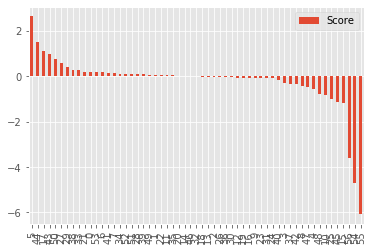

In [22]:
importance = logit_final1.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], v
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### Stochastic Gradient Descent Classifier

In [23]:
from sklearn.linear_model import SGDClassifier

#### SMOTE

In [24]:
# SMOTE
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nSGD Baseline recall score: ", recall_score(y_test,sgd.predict(X_test)))

SMOTE: 
SGD Baseline recall score:  1.0


In [25]:
grid_para_sgd = {
    'max_iter': [1, 10, 100, 1000],
    'alpha': np.linspace(1e-3,5e-3,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring='recall', n_jobs=-1)
%time grid_search_sgd.fit(X_train_Bal, y_train_Bal)

CPU times: user 1.59 s, sys: 48.7 ms, total: 1.64 s
Wall time: 9.08 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([0.001     , 0.00113793, 0.00127586, 0.00141379, 0.00155172,
       0.00168966, 0.00182759, 0.00196552, 0.00210345, 0.00224138,
       0.00237931, 0.00251724, 0.00265517, 0.0027931 , 0.00293103,
       0.00306897, 0.0032069 , 0.00334483, 0.00348276, 0.00362069,
       0.00375862, 0.00389655, 0.00403448, 0.00417241, 0.00431034,
       0.00444828, 0.00458621, 0.00472414, 0.00486207, 0.005     ]),
                         'max_iter': [1, 10, 100, 1000]},
             scoring='recall')

In [26]:
print("SMOTE: \n")
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set recall score: ", grid_search_sgd.best_score_)
sgd_final1 = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set recall score: ", recall_score(y_test,sgd_final1.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final1.predict(X_test)))
SMOTE_sgd = recall_score(y_test,sgd_final1.predict(X_test))

SMOTE: 

SGD Grid Search best params:  {'alpha': 0.001, 'max_iter': 1000}
SGD Grid Search Training set recall score:  0.9709440400363967
SGD Best Estimator Validation set recall score:  1.0
SGD Best Estimator Validation set business score:  0.6207321553498625


In [27]:
business_scores.loc[1] = 'SGD', round(SMOTE_sgd, 2)

#### imblearn balanced

In [32]:
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_ros, y_ros)
print("Imblearn Balanced: \nSGD Baseline recall score: ", recall_score(y_test,sgd.predict(X_test)))

Imblearn Balanced: 
SGD Baseline recall score:  1.0


In [33]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(5e-4,1e-4,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring=businessscore, n_jobs=-1)
%time grid_search_sgd.fit(X_ros, y_ros)

CPU times: user 8.2 s, sys: 249 ms, total: 8.45 s
Wall time: 32.7 s


/home/truong/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([0.0005    , 0.00048621, 0.00047241, 0.00045862, 0.00044483,
       0.00043103, 0.00041724, 0.00040345, 0.00038966, 0.00037586,
       0.00036207, 0.00034828, 0.00033448, 0.00032069, 0.0003069 ,
       0.0002931 , 0.00027931, 0.00026552, 0.00025172, 0.00023793,
       0.00022414, 0.00021034, 0.00019655, 0.00018276, 0.00016897,
       0.00015517, 0.00014138, 0.00012759, 0.00011379, 0.0001    ]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring=make_scorer(businessgain))

In [34]:
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set recall score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set recall score: ", recall_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))
imblearn_sgd = businessgain(y_test,sgd_final.predict(X_test))

SGD Grid Search best params:  {'alpha': 0.0001, 'max_iter': 100}
SGD Grid Search Training set recall score:  0.9205077792285117
SGD Best Estimator Validation set recall score:  1.0
SGD Best Estimator Validation set business score:  0.48877278361027693


#### Comparing SMOTE with imblearn

In [35]:
print('SMOTE SGD business score: ', SMOTE_sgd, '\nimblearn SGD business score: ', imblearn_sgd)

SMOTE SGD business score:  0.5833971117738559 
imblearn SGD business score:  0.48877278361027693


#### SGD feature Importance

,Feature,Score
56,Both_Service,3.142976
11,Race1,1.807367
12,Race2,1.607166
43,Diagnosis_1_Count,1.549890
55,Outpatient,1.273743
44,Diagnosis_2_Count,1.084526
54,Inpatient,1.049208
38,Procedure_1_Count,0.751129
51,Diagnosis_9_Count,0.727760
13,Race3,0.633669


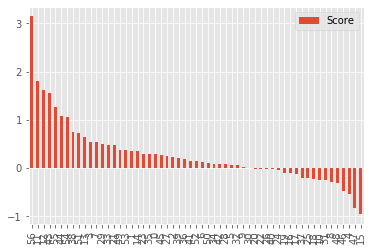

In [28]:
importance = sgd_final1.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], v
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### Discriminant Analysis

#### SMOTE

In [29]:
from sklearn import discriminant_analysis

#### Your code here, name your model object LDA
LDA = discriminant_analysis.LinearDiscriminantAnalysis()
LDA.fit(X_train_Bal, y_train_Bal)

LinearDiscriminantAnalysis()

In [44]:
y_predict = LDA.predict(X_test)
print("SMOTE: \nLDA Baseline validation set recall score: ", recall_score(y_test,y_predict))
print("LDA Baseline validation set business score: ", businessgain(y_test,y_predict))

SMOTE: 
LDA Baseline validation set recall score:  0.801980198019802
LDA Baseline validation set business score:  0.4498539968751928


In [45]:
QDA = discriminant_analysis.QuadraticDiscriminantAnalysis()
QDA.fit(X_train_Bal, y_train_Bal)
y_predict = QDA.predict(X_test)

print("QDA Baseline validation set recall score: ", recall_score(y_test,y_predict))
print("QDA Baseline validation set business score: ", businessgain(y_test,y_predict))


QDA Baseline validation set recall score:  0.5148514851485149
QDA Baseline validation set business score:  -0.055193968164801564


/home/annie/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Non-linear Models


### K-Nearest Neighbors

#### SMOTE

In [30]:
knn = KNeighborsClassifier()
knn.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nKNN Baseline Training Set recall score: ", recall_score(y_train_Bal,knn.predict(X_train_Bal)))
print("KNN Baseline Validation Set recall score: ", recall_score(y_test,knn.predict(X_test)))

SMOTE: 
KNN Baseline Training Set recall score:  0.9987254652052001
KNN Baseline Validation Set recall score:  0.8514851485148515


In [31]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = 'recall')

knn_GS.fit(X_train_Bal, y_train_Bal)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring='recall', verbose=1)

In [32]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_knn.predict(X_train_Bal)))
print("KNN Grid Search Validation set Recall score: ", recall_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
SMOTE_knn = recall_score(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 71}
KNN Grid Search Training set Recall score:  0.9681366301300025
KNN Grid Search Validation set Recall score:  0.9405940594059405
KNN Grid Search Validation set business score:  0.6514127092793162


In [33]:
business_scores.loc[2] = 'KNN', round(SMOTE_knn, 2)

#### imblearn

In [253]:
knn = KNeighborsClassifier()
knn.fit(X_ros, y_ros)
print("imblearn: \nKNN Baseline Training Set recall score: ", recall_score(y_ros,knn.predict(X_ros)))
print("KNN Baseline Validation Set recall score: ", recall_score(y_test,knn.predict(X_test)))

imblearn: 
KNN Baseline Training Set recall score:  1.0
KNN Baseline Validation Set recall score:  0.7425742574257426


In [254]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = businessscore)

knn_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [255]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set Recall score: ", recall_score(y_ros, best_knn.predict(X_ros)))
print("KNN Grid Search Validation set Recall score: ", recall_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
imblearn_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 79}
KNN Grid Search Training set Recall score:  0.9026255416772878
KNN Grid Search Validation set Recall score:  0.9405940594059405
KNN Grid Search Validation set business score:  0.682787664797819


#### Comparing SMOTE and imblearn

In [256]:
print('SMOTE KNN business score: ', SMOTE_knn, '\nimblearn KNN business score: ', imblearn_knn)

SMOTE KNN business score:  0.6850565816178519 
imblearn KNN business score:  0.682787664797819


In [257]:
confusion_matrix(y_test, best_knn.predict(X_test))

array([[772, 209],
       [  6,  95]])

### Support Vector Machine

#### SMOTE

In [34]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_Bal, y_train_Bal)

SVC(class_weight='balanced')

In [35]:
# baseline score
svm_train_recall = recall_score(y_train_Bal, svm.predict(X_train_Bal))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('SMOTE: \nSVM BaseLine Train Set Recall Score:', svm_train_recall)
print('SVM BaseLine Validation Set Recall Score:', svm_test_recall)

SMOTE: 
SVM BaseLine Train Set Recall Score: 0.8982921233749681
SVM BaseLine Validation Set Recall Score: 0.8910891089108911


In [37]:
# grid search 
params = {'C': np.linspace(1,2,10), 
          'kernel': ['rbf'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = 'recall')
svm_GS.fit(X_train_Bal, y_train_Bal)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ]),
                         'gamma': ('auto', 'scale'), 'kernel': ['rbf']},
             return_train_score=True, scoring='recall', verbose=1)

In [38]:
print("SVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_svm.predict(X_train_Bal)))
print("SVM Grid Search Validation set Recall score: ", recall_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
SMOTE_svm = recall_score(y_test, best_svm.predict(X_test))

SVM Grid Search Best params:  {'C': 1.5555555555555556, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Grid Search Training set Recall score:  0.9770583736936018
SVM Grid Search Validation set Recall score:  0.6831683168316832
Test Set business Score: 0.2519103253017677


In [39]:
business_scores.loc[3] = 'SVM', round(SMOTE_svm, 2)

#### imblearn

In [262]:
svm = SVC(class_weight='balanced')
svm.fit(X_ros, y_ros)

SVC(class_weight='balanced')

In [263]:
# baseline score
svm_train_recall = recall_score(y_ros, svm.predict(X_ros))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('imblearn: \nSVM BaseLine Train Set Recall Score:', svm_train_recall)
print('SVM BaseLine Validation Set Recall Score:', svm_test_recall)

imblearn: 
SVM BaseLine Train Set Recall Score: 0.862605149120571
SVM BaseLine Validation Set Recall Score: 0.9405940594059405


In [264]:
# grid search 
params = {'C': np.logspace(-1,2,10), 
          'kernel': ['rbf','linear'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = businessscore)
svm_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 442.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 641.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                         'gamma': ('auto', 'scale'),
                         'kernel': ['rbf', 'linear']},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [265]:
print("imblearn: \nSVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set Recall score: ", recall_score(y_ros, best_svm.predict(X_ros)))
print("SVM Grid Search Validation set Recall score: ", recall_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
imblearn_svm = businessgain(y_test, best_svm.predict(X_test))

imblearn: 
SVM Grid Search Best params:  {'C': 21.54434690031882, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Grid Search Training set Recall score:  1.0
SVM Grid Search Validation set Recall score:  0.2871287128712871
Test Set business Score: -0.5281725760972439


#### Comparing SMOTE and imblearn

In [424]:
print('SMOTE svm business score: ', SMOTE_svm, '\nimblearn svm business score: ', imblearn_svm)

SMOTE svm business score:  0.5837777638077201 
imblearn svm business score:  -0.5281725760972439


,Feature,Score
50,Diagnosis_8_Count,1.153842
44,Diagnosis_2_Count,0.979785
5,Duplicate_Claims_Percent,0.968759
43,Diagnosis_1_Count,0.753280
17,ChronicCond_KidneyDisease_1,0.542340
56,Both_Service,0.415212
41,Procedure_4_Count,0.278769
7,Avg_Cost,0.222785
38,Procedure_1_Count,0.212130
52,Norm_FraudNeighbors,0.210212


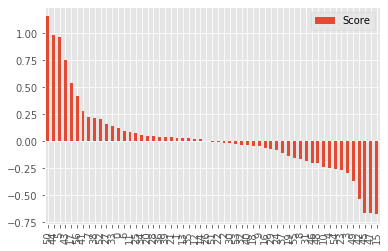

In [133]:
#recall = TP / (TP+FN) 
confusion_matrix(y_test, best_svm.predict(X_test))
importance = best_svm.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], v
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores.head(10)


## Tree-Based Label Encoding

In [40]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(features.Service_Type)
features.Service_Type = le.transform(features.Service_Type)
features.columns

Index(['Provider', 'Phys_Count', 'Patient_Count', 'Norm_Patient_Count',
       'Claim_Count', 'Norm_Claim_Count', 'Service_Type', 'Both_Service',
       'Inpatient', 'Outpatient', 'Inpatient_Count', 'Outpatient_Count',
       'Norm_Inpatient_Count', 'Norm_Outpatient_Count', 'DuplicateClaims',
       'Duplicate_Claims_Percent', 'AvgClaimDuration', 'Avg_Cost', 'Avg_Age',
       'Gender1', 'Gender2', 'Race1', 'Race2', 'Race3', 'Race5',
       'ChronicCond_Alzheimer_1', 'ChronicCond_Alzheimer_2',
       'ChronicCond_KidneyDisease_1', 'ChronicCond_KidneyDisease_2',
       'ChronicCond_Cancer_1', 'ChronicCond_Cancer_2',
       'ChronicCond_ObstrPulmonary_1', 'ChronicCond_ObstrPulmonary_2',
       'ChronicCond_Depression_1', 'ChronicCond_Depression_2',
       'ChronicCond_Diabetes_1', 'ChronicCond_Diabetes_2',
       'ChronicCond_IschemicHeart_1', 'ChronicCond_IschemicHeart_2',
       'ChronicCond_Osteoporasis_1', 'ChronicCond_Osteoporasis_2',
       'ChronicCond_rheumatoidarthritis_1',
     

In [41]:
X = features.drop(['PotentialFraud', 'Inpatient','Outpatient','Provider','Both_Service', 'Inpatient_Count', 'Outpatient_Count',
                  'Patient_Count', 'DuplicateClaims', 'Claim_Count'], axis=1)
y = features['PotentialFraud']

In [42]:
#create seperate dataset with dummy variables to add back after scaling
non_num = X[['isFraudConnected','Service_Type']]

#drop dummy variables
X = X.drop(['isFraudConnected','Service_Type'], axis =1)

In [43]:
#scale on the training set 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=(X.columns), index=X.index)
#add back dummy variables to scaled dataset 
X_scaled = pd.concat((X_scaled, non_num), axis=1)

In [44]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True);
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [45]:
# SMOTE upsampling for all models
oversample = over_sampling.SMOTE()
X_train_Bal, y_train_Bal = oversample.fit_resample(X_train, y_train)

y_train_Bal.value_counts()

1    3923
0    3923
Name: PotentialFraud, dtype: int64

### Random Forest

In [46]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier()

# fit RF model on SMOTE training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train_Bal, y_train_Bal)

# baseline score
print('SMOTE: \nRF BaseLine Train Set Recall Score:', recall_score(y_train_Bal, randomForest.predict(X_train_Bal)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

SMOTE: 
RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.693069306930693


In [47]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='recall', cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_train_Bal, y_train_Bal)

CPU times: user 13.6 s, sys: 323 ms, total: 13.9 s
Wall time: 13min 49s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring='recall')

In [48]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_RF.predict(X_train_Bal)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
SMOTE_rf = recall_score(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 90}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  0.7722772277227723
RF Grid Search Validation set Business score:  0.4578119313649778


In [49]:
business_scores.loc[4] = 'RF', round(SMOTE_rf, 2)

#### imblearn

In [271]:
randomForest.set_params(random_state=0)

randomForest.fit(X_ros, y_ros)

# baseline score
print('imblearn: \nRF BaseLine Train Set Recall Score:', recall_score(y_ros, randomForest.predict(X_ros)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

imblearn: 
RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.5742574257425742


In [272]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring=businessscore, cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_ros, y_ros)

CPU times: user 11.8 s, sys: 339 ms, total: 12.2 s
Wall time: 7min 45s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring=make_scorer(businessgain))

In [273]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_ros, best_RF.predict(X_ros)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
imblearn_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 24, 'n_estimators': 20}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  0.6039603960396039
RF Grid Search Validation set Business score:  0.142402502614099


#### comparing SMOTE and imblearn

In [50]:
#print('SMOTE rf business score: ', SMOTE_rf, '\nimblearn rf business score: ', imblearn_rf)
list_of_tuples = list(zip(X_train_Bal.columns, best_RF.feature_importances_))
df = pd.DataFrame(list_of_tuples, columns = ['Feature', 'Score'])
df.sort_values(by='Score', ascending=False)

,Feature,Score
51,Diagnosis_9_Count,0.110543
49,Diagnosis_7_Count,0.063554
50,Diagnosis_8_Count,0.063523
38,Procedure_1_Count,0.057615
48,Diagnosis_6_Count,0.056623
39,Procedure_2_Count,0.055595
46,Diagnosis_4_Count,0.032886
47,Diagnosis_5_Count,0.029976
3,Norm_Inpatient_Count,0.029693
4,Norm_Outpatient_Count,0.027882


### XG BOOST 

In [51]:
from xgboost import XGBClassifier

#SMOTE
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train_Bal, y_train_Bal)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
print('SMOTE: \nXGB BaseLine Train Set Recall Score:', recall_score(y_train_Bal, xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, xgb.predict(X_test)))

SMOTE: 
XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.5742574257425742


In [53]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': np.arange(start=600, stop=750, step=10),
                 'learning_rate': [1e-4,1e-3,5],
                 'n_estimators':  np.arange(start=10, stop=15, step=1),
                 'max_depth': np.arange(start=10, stop=15, step=1),
                 'subsample': [0.9]
                 } 

In [54]:
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring='recall', cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_train_Bal, y_train_Bal)

CPU times: user 46.6 s, sys: 1.3 s, total: 47.9 s
Wall time: 22min 4s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                                     verbosity=None),
             n_jobs=-1,
             param_grid={'l

In [55]:
grid_search_xgb.best_params_

{'learning_rate': 5,
 'max_depth': 10,
 'n_estimators': 10,
 'scale_pos_weight': 620,
 'subsample': 0.9}

In [56]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set Recall Score:', recall_score(y_train_Bal, best_xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
SMOTE_xgb = recall_score(y_test, best_xgb.predict(X_test))

XGB BaseLine Train Set Recall Score: 0.9936273260260005
XGB BaseLine Validation Set Recall Score: 1.0
XGB BaseLine Validation Set business Score: 0.09474025401025575


In [57]:
business_scores.loc[5] = 'XGBoost', round(SMOTE_xgb, 2)

#### imblearn

In [281]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_ros, y_ros)
print('imblearn: \nXGB BaseLine Train Set Recall Score:', recall_score(y_ros, xgb.predict(X_ros)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, xgb.predict(X_test)))

imblearn: 
XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.6336633663366337


In [282]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [400,500,600],
                 'learning_rate': [0.001, 0.010, 0.1],
                 'n_estimators': [2,5,10] ,
                 'max_depth': [1,3,10],
                 'subsample': [0.9]
                 }
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring=businessscore, cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_ros, y_ros)

CPU times: user 6.54 s, sys: 261 ms, total: 6.8 s
Wall time: 25.5 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_metho

In [283]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set Recall Score:', recall_score(y_ros, best_xgb.predict(X_ros)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
imblearn_xgb = businessgain(y_test, best_xgb.predict(X_test))

XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.9900990099009901
XGB BaseLine Validation Set business Score: 0.5529449490647207


#### comparing SMOTE and imblearn

In [284]:
print('SMOTE xgb business score: ', SMOTE_xgb, '\nimblearn xgb business score: ', imblearn_xgb)

SMOTE xgb business score:  0.47039305782969504 
imblearn xgb business score:  0.5529449490647207


In [285]:
confusion_matrix(y_test, best_xgb.predict(X_test))

array([[519, 462],
       [  1, 100]])

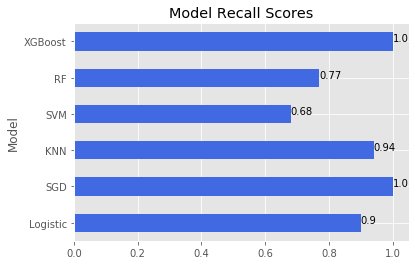

In [74]:
business_scores.plot.barh(x = 'Model', color = 'royalblue', legend=None)
plt.title('Model Recall Scores')
business_scores
for index, value in enumerate(business_scores['Score']):
    plt.text(value, index, str(round(value,4)))